In [1]:
import os
from scipy.io import loadmat
import matplotlib.pyplot as plt
from astropy.io import fits
import imageio
import numpy as np
import scipy
from scipy import linalg
import imageio.v2 as imageio
from imageio.core import util as imageio_util
import matplotlib.cm as cm
from psf_functions import *
from matplotlib.patches import Rectangle
from datetime import datetime, timedelta
from psf_functions import encircled_energy_in_3x3
from scipy.ndimage import center_of_mass
import pandas as pd
import re

folder_data = '/Volumes/SanDisk/PAPYRUS_run2/30.09.25/record/2025-10-01_06-58-49'

%matplotlib inline


# Data

In [2]:
# --------------------------------------------------------------------
# MANUAL LIST OF FOLDERS
# --------------------------------------------------------------------
folders = [
    # 30.09.25
    '/Volumes/SanDisk/PAPYRUS_run2/30.09.25/record/2025-10-01_06-58-49',  # 3s
    '/Volumes/SanDisk/PAPYRUS_run2/30.09.25/record/2025-10-01_06-59-09',  # 4s
    '/Volumes/SanDisk/PAPYRUS_run2/30.09.25/record/2025-10-01_07-10-33',  # 3s
    '/Volumes/SanDisk/PAPYRUS_run2/30.09.25/record/2025-10-01_07-10-46',  # 4s

    # 01.10.25
    '/Volumes/SanDisk/PAPYRUS_run2/01.10.25/record/2025-10-02_03-27-19',
    '/Volumes/SanDisk/PAPYRUS_run2/01.10.25/record/2025-10-02_03-30-43',
    '/Volumes/SanDisk/PAPYRUS_run2/01.10.25/record/2025-10-02_03-12-37',
    '/Volumes/SanDisk/PAPYRUS_run2/01.10.25/record/2025-10-02_03-13-19',
    '/Volumes/SanDisk/PAPYRUS_run2/01.10.25/record/2025-10-02_03-10-56',
    '/Volumes/SanDisk/PAPYRUS_run2/01.10.25/record/2025-10-02_03-11-10',
    '/Volumes/SanDisk/PAPYRUS_run2/01.10.25/record/2025-10-02_02-49-11',
    '/Volumes/SanDisk/PAPYRUS_run2/01.10.25/record/2025-10-02_02-48-31',
    '/Volumes/SanDisk/PAPYRUS_run2/01.10.25/record/2025-10-02_02-27-34',
    '/Volumes/SanDisk/PAPYRUS_run2/01.10.25/record/2025-10-02_02-27-46',
    '/Volumes/SanDisk/PAPYRUS_run2/01.10.25/record/2025-10-02_02-32-36',
    '/Volumes/SanDisk/PAPYRUS_run2/01.10.25/record/2025-10-02_02-32-58',
    '/Volumes/SanDisk/PAPYRUS_run2/01.10.25/record/2025-10-02_02-33-47',
    '/Volumes/SanDisk/PAPYRUS_run2/01.10.25/record/2025-10-02_02-34-00',
    '/Volumes/SanDisk/PAPYRUS_run2/01.10.25/record/2025-10-02_02-36-37',
    '/Volumes/SanDisk/PAPYRUS_run2/01.10.25/record/2025-10-02_02-36-51',
    '/Volumes/SanDisk/PAPYRUS_run2/01.10.25/record/2025-10-02_02-37-57',
    '/Volumes/SanDisk/PAPYRUS_run2/01.10.25/record/2025-10-02_02-38-21',

    # 02.10.25
    '/Volumes/SanDisk/PAPYRUS_run2/02.10.25/record/2025-10-03_00-23-57',
    '/Volumes/SanDisk/PAPYRUS_run2/02.10.25/record/2025-10-03_00-24-16',
    '/Volumes/SanDisk/PAPYRUS_run2/02.10.25/record/2025-10-03_00-46-36',
    '/Volumes/SanDisk/PAPYRUS_run2/02.10.25/record/2025-10-03_00-46-45',
    #'/Volumes/SanDisk/PAPYRUS_run2/02.10.25/record/2025-10-03_00-48-14',
    #'/Volumes/SanDisk/PAPYRUS_run2/02.10.25/record/2025-10-03_00-48-46',
]

# --------------------------------------------------------------------
# Crop coords per date
# --------------------------------------------------------------------
crop_coords = {
    '30.09.25': dict(x0=275, x1=375, y0=220, y1=320),
    '01.10.25': dict(x0=225, x1=425, y0=200, y1=400),
    '02.10.25': dict(x0=285, x1=385, y0=220, y1=320),
}



In [3]:
# --------------------------------------------------------------------
# Helper functions
# --------------------------------------------------------------------
def get_pyramid_type(path):
    idx = folders.index(path)
    return '3s' if idx % 2 == 0 else '4s'

def get_time_from_path(path):
    m = re.search(r'_(\d{2}-\d{2}-\d{2})$', path)
    return m.group(1) if m else None

def get_date_from_path(path):
    m = re.search(r"/(\d{2}\.\d{2}\.\d{2})/", path)
    return m.group(1) if m else None

def get_datetime_from_path(path):
    m = re.search(r'(\d{4}-\d{2}-\d{2})_(\d{2}-\d{2}-\d{2})', path)
    if not m:
        return None
    return datetime.strptime(m.group(0), '%Y-%m-%d_%H-%M-%S')

def compute_encircled_energy(folder_path):
    date_str = get_date_from_path(folder_path)
    coords = crop_coords.get(date_str)

    cube = fits.getdata(os.path.join(folder_path, 'cred2.fits')).astype(float)
    psf_data = cube[:, coords['y0']:coords['y1'], coords['x0']:coords['x1']]
    psf = np.var(psf_data, axis=0)
    psf_norm = psf / psf.sum()

    y_com, x_com = center_of_mass(psf_norm)
    y_peak, x_peak = np.unravel_index(np.argmax(psf_norm), psf_norm.shape)
    ee = encircled_energy_in_3x3(psf_norm, x_peak, y_peak)

    # Inline PSF plot (optional)
    fig, ax = plt.subplots(figsize=(5, 5))
    im = ax.imshow(np.log10(np.clip(psf_norm, 1e-8, None)), origin='lower', cmap='inferno')
    ax.scatter(x_peak, y_peak, color='cyan', marker='x', s=80, label=f'Peak ({x_peak:.1f}, {y_peak:.1f})')
    ax.scatter(x_com, y_com, color='lime', marker='+', s=80, label=f'CoM ({x_com:.2f}, {y_com:.2f})')
    ax.set_title(f"{get_pyramid_type(folder_path)} | {date_str} | EE={ee:.4f}")
    ax.legend(fontsize=8)
    plt.colorbar(im, ax=ax, label='log10(norm intensity)')
    plt.tight_layout()
    plt.show()

    return {
        'folder': folder_path,
        'datetime': get_datetime_from_path(folder_path),   # <-- replaced
        'pyramid': get_pyramid_type(folder_path),
        'EE': ee,
    }

def compute_modes_rms_kl(modes):
    """Compute RMS per mode along time axis."""
    return np.sqrt(np.mean(modes**2, axis=0))

def compute_rms_for_pyramid(pyramid_type):
    """Compute RMS of first 100 KL modes for all folders of given pyramid type."""
    rms_in_vals, rms_out_vals, obs_labels = [], [], []

    for folder in folders:
        if get_pyramid_type(folder) != pyramid_type:
            continue
        try:
            modes_in = fits.getdata(os.path.join(folder, 'modes_in.fits'))
            modes_out = fits.getdata(os.path.join(folder, 'modes_out.fits'))

            rms_modes_in_kl = compute_modes_rms_kl(modes_in)
            rms_modes_out_kl = compute_modes_rms_kl(modes_out)

            # Average RMS for first 100 modes
            rms_in_100 = np.sqrt(np.mean(rms_modes_in_kl[:100]**2))
            rms_out_100 = np.sqrt(np.mean(rms_modes_out_kl[:100]**2))

            rms_in_vals.append(rms_in_100)
            rms_out_vals.append(rms_out_100)
            obs_labels.append(os.path.basename(folder))

        except Exception as e:
            print(f"⚠️ Error in {folder}: {e}")

    return rms_in_vals, rms_out_vals, obs_labels

def build_compressed_timeline(df,
                              tiny_gap=timedelta(seconds=30),
                              short_gap=timedelta(minutes=5),
                              medium_gap=timedelta(hours=3),
                              short_offset=timedelta(minutes=5),
                              medium_offset=timedelta(minutes=10),
                              daytime_offset=timedelta(minutes=20)):
    """
    Build a compressed timeline for observations based on temporal gaps.

    Parameters
    ----------
    df : DataFrame
        Must contain a sorted 'datetime' column.
    tiny_gap : timedelta
        Gaps smaller than this keep their original delta.
    short_gap : timedelta
        Gaps smaller than this get mapped to short_offset.
    medium_gap : timedelta
        Gaps smaller than this get mapped to medium_offset.
    short_offset, medium_offset, daytime_offset : timedelta
        Fixed offsets applied depending on gap size.

    Returns
    -------
    compressed_times : list of datetime
        The compressed timeline.
    """

    compressed_times = [df['datetime'].iloc[0]]

    for i in range(1, len(df)):
        delta = df['datetime'].iloc[i] - df['datetime'].iloc[i - 1]

        if delta <= tiny_gap:
            new_time = compressed_times[-1] + delta
        elif delta <= short_gap:
            new_time = compressed_times[-1] + short_offset
        elif delta <= medium_gap:
            new_time = compressed_times[-1] + medium_offset
        else:
            new_time = compressed_times[-1] + daytime_offset

        compressed_times.append(new_time)

    return compressed_times


## Encircled energy


→ Processing /Volumes/SanDisk/PAPYRUS_run2/30.09.25/record/2025-10-01_06-58-49


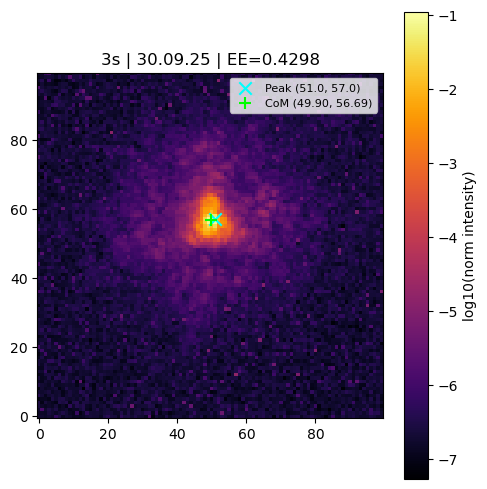


→ Processing /Volumes/SanDisk/PAPYRUS_run2/30.09.25/record/2025-10-01_06-59-09


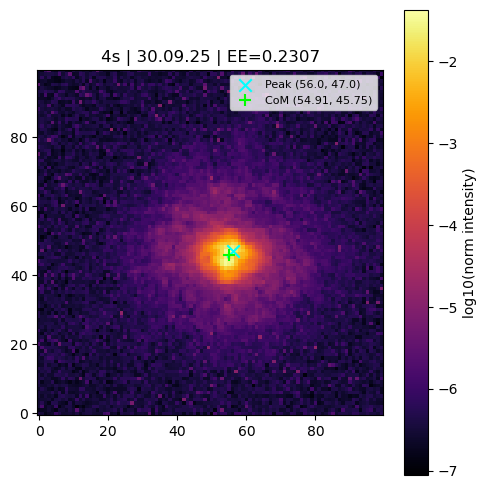


→ Processing /Volumes/SanDisk/PAPYRUS_run2/30.09.25/record/2025-10-01_07-10-33


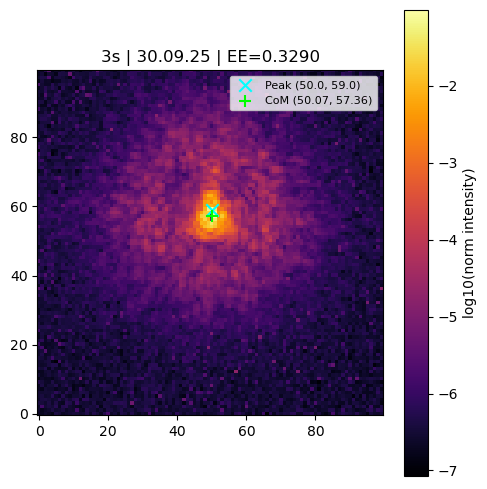


→ Processing /Volumes/SanDisk/PAPYRUS_run2/30.09.25/record/2025-10-01_07-10-46


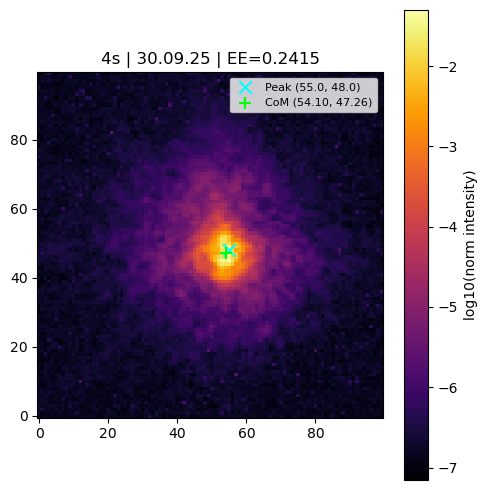


→ Processing /Volumes/SanDisk/PAPYRUS_run2/01.10.25/record/2025-10-02_03-27-19


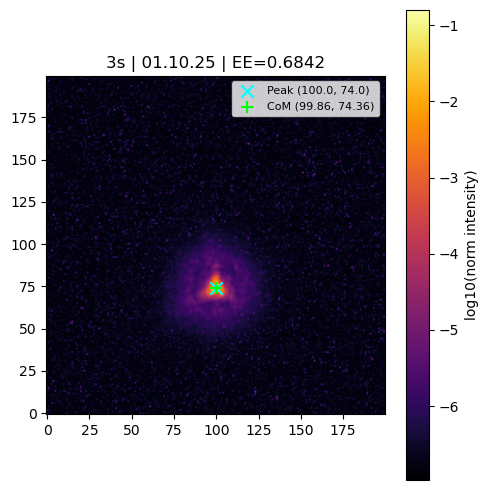


→ Processing /Volumes/SanDisk/PAPYRUS_run2/01.10.25/record/2025-10-02_03-30-43


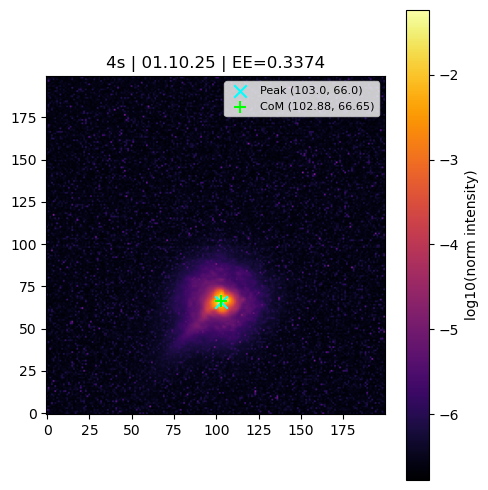


→ Processing /Volumes/SanDisk/PAPYRUS_run2/01.10.25/record/2025-10-02_03-12-37


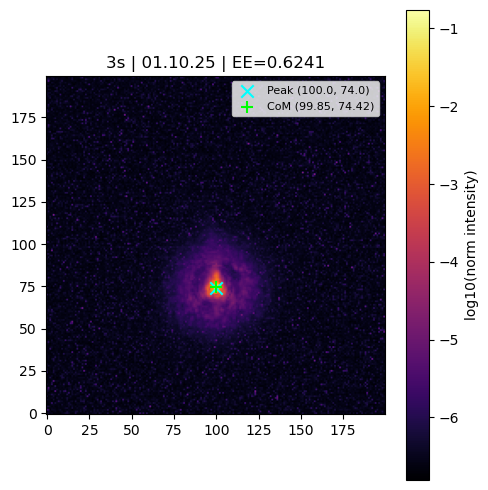


→ Processing /Volumes/SanDisk/PAPYRUS_run2/01.10.25/record/2025-10-02_03-13-19


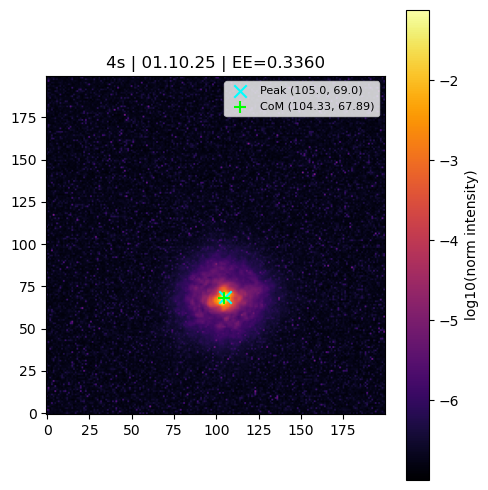


→ Processing /Volumes/SanDisk/PAPYRUS_run2/01.10.25/record/2025-10-02_03-10-56


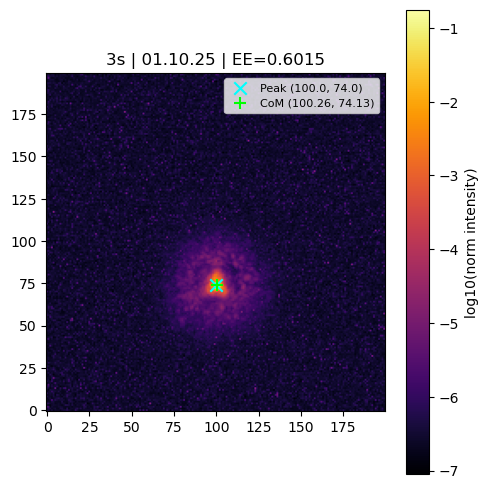


→ Processing /Volumes/SanDisk/PAPYRUS_run2/01.10.25/record/2025-10-02_03-11-10


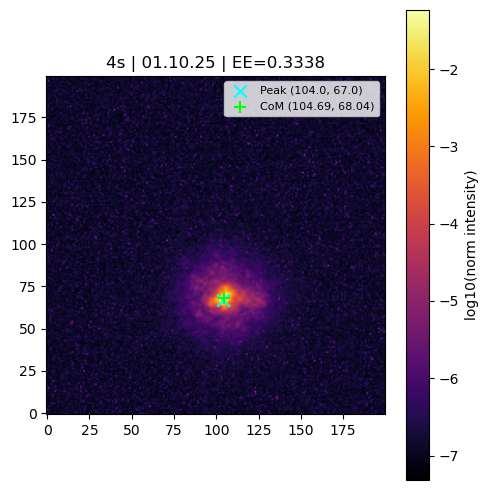


→ Processing /Volumes/SanDisk/PAPYRUS_run2/01.10.25/record/2025-10-02_02-49-11


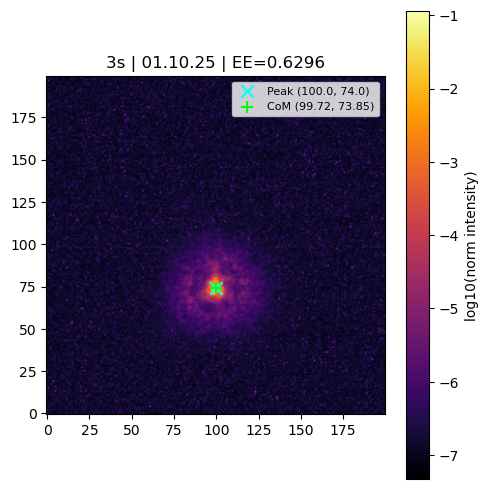


→ Processing /Volumes/SanDisk/PAPYRUS_run2/01.10.25/record/2025-10-02_02-48-31


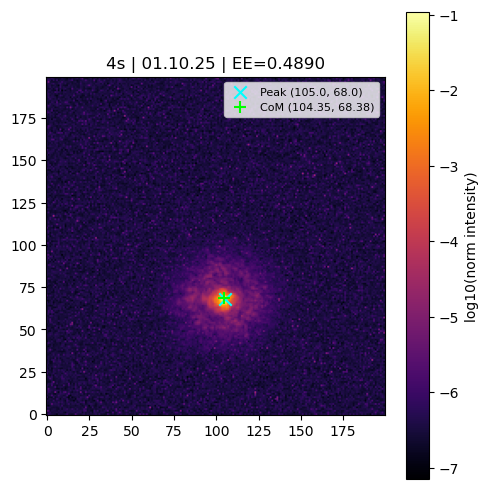


→ Processing /Volumes/SanDisk/PAPYRUS_run2/01.10.25/record/2025-10-02_02-27-34


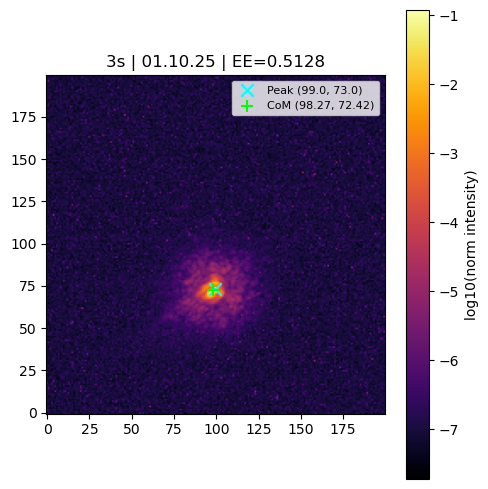


→ Processing /Volumes/SanDisk/PAPYRUS_run2/01.10.25/record/2025-10-02_02-27-46


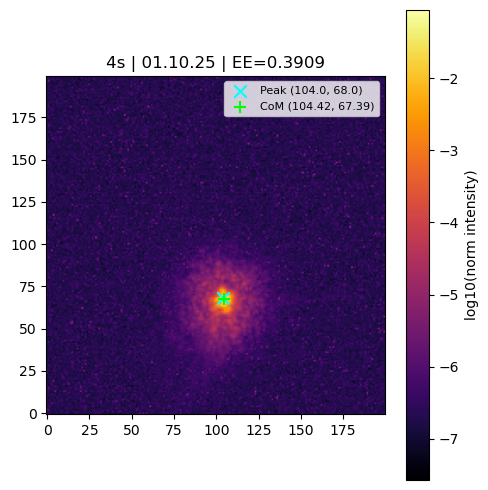


→ Processing /Volumes/SanDisk/PAPYRUS_run2/01.10.25/record/2025-10-02_02-32-36


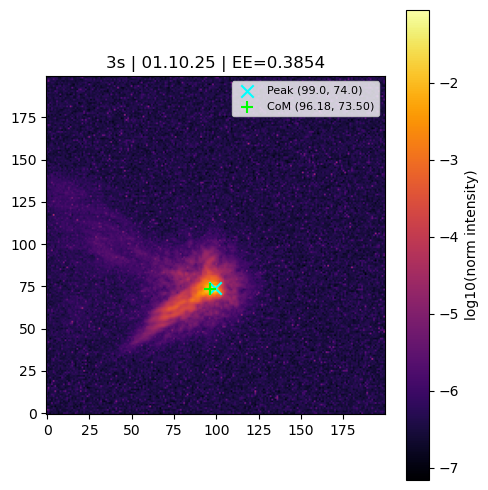


→ Processing /Volumes/SanDisk/PAPYRUS_run2/01.10.25/record/2025-10-02_02-32-58


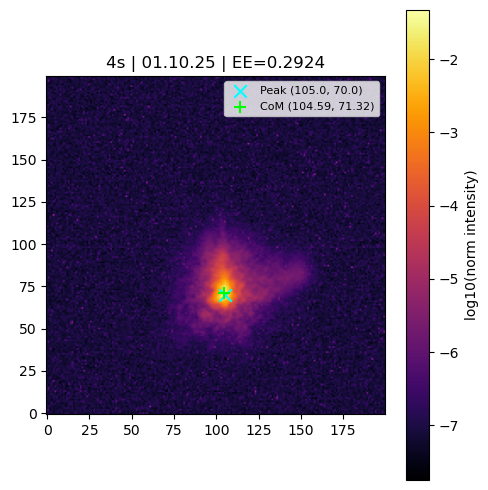


→ Processing /Volumes/SanDisk/PAPYRUS_run2/01.10.25/record/2025-10-02_02-33-47


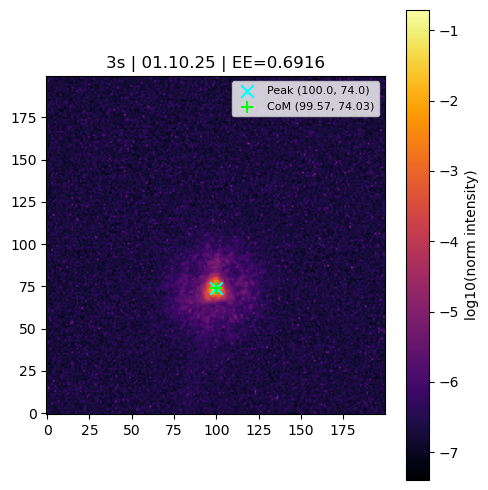


→ Processing /Volumes/SanDisk/PAPYRUS_run2/01.10.25/record/2025-10-02_02-34-00


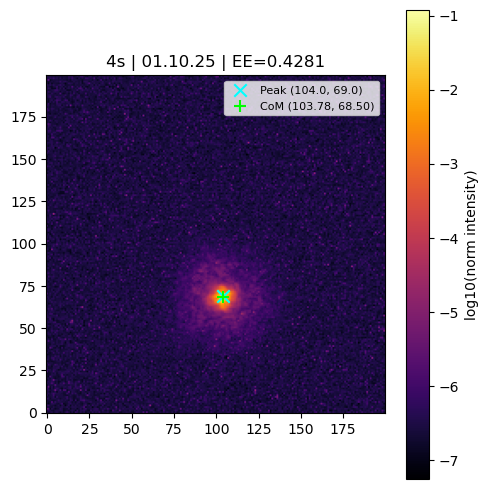


→ Processing /Volumes/SanDisk/PAPYRUS_run2/01.10.25/record/2025-10-02_02-36-37


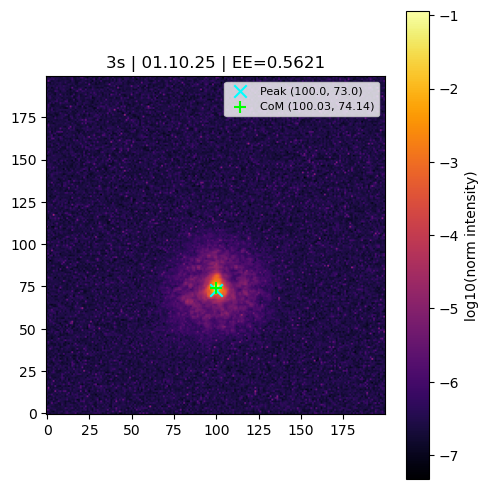


→ Processing /Volumes/SanDisk/PAPYRUS_run2/01.10.25/record/2025-10-02_02-36-51


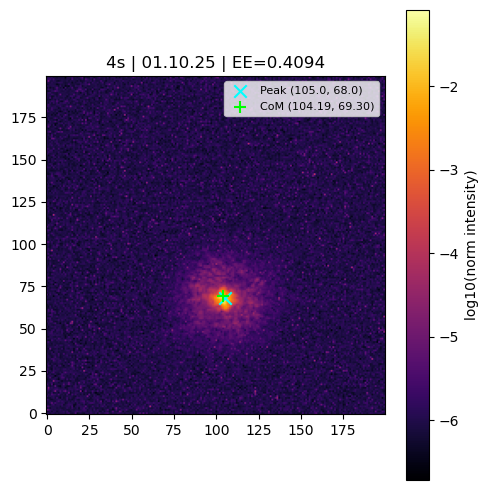


→ Processing /Volumes/SanDisk/PAPYRUS_run2/01.10.25/record/2025-10-02_02-37-57


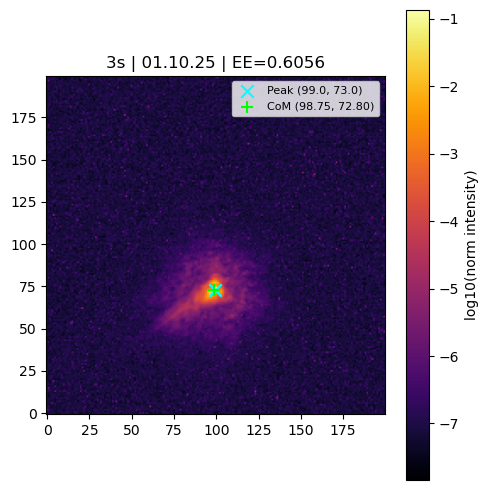


→ Processing /Volumes/SanDisk/PAPYRUS_run2/01.10.25/record/2025-10-02_02-38-21


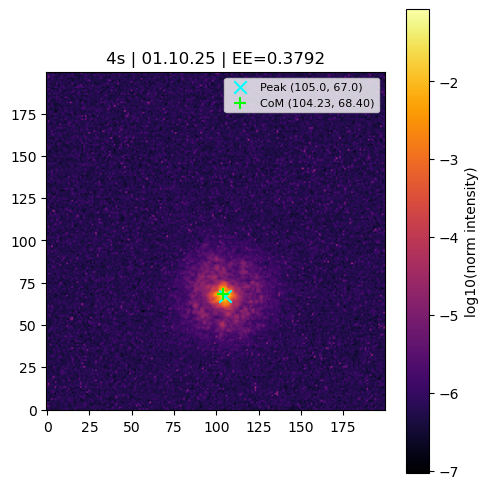


→ Processing /Volumes/SanDisk/PAPYRUS_run2/02.10.25/record/2025-10-03_00-23-57


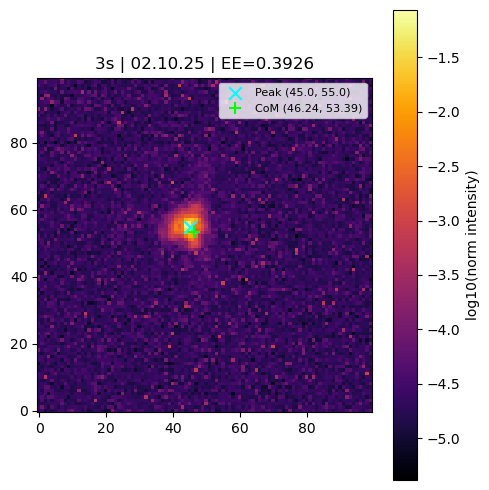


→ Processing /Volumes/SanDisk/PAPYRUS_run2/02.10.25/record/2025-10-03_00-24-16


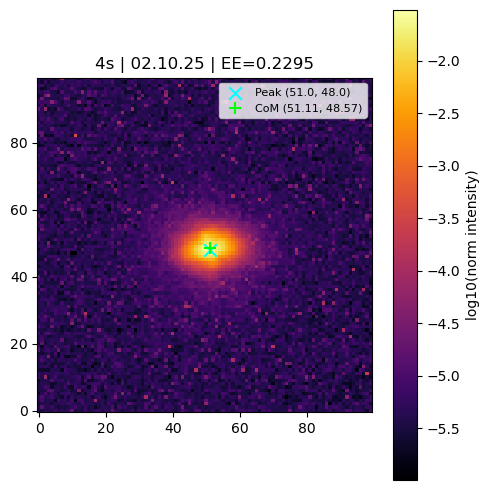


→ Processing /Volumes/SanDisk/PAPYRUS_run2/02.10.25/record/2025-10-03_00-46-36


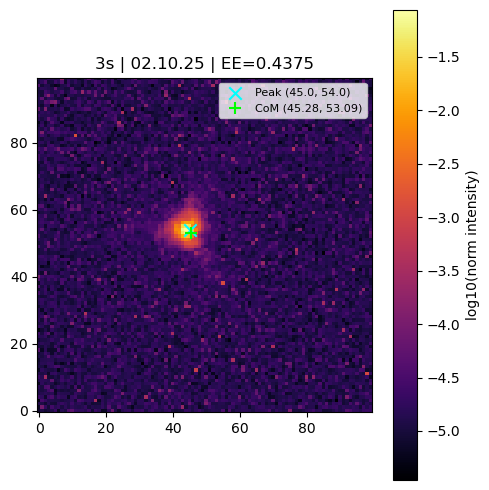


→ Processing /Volumes/SanDisk/PAPYRUS_run2/02.10.25/record/2025-10-03_00-46-45


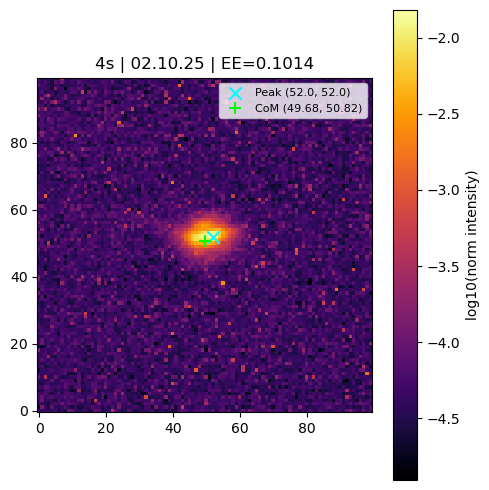

In [4]:
# --------------------------------------------------------------------
# Run on all folders
# --------------------------------------------------------------------
results = []
for f in folders:
    try:
        print(f"\n→ Processing {f}")
        res = compute_encircled_energy(f)
        if res:
            results.append(res)
    except Exception as e:
        print(f"❌ Error in {f}: {e}")




Encircled Energy Comparison (3s vs 4s Pyramid):
------------------------------------------------------------
Obs#       EE (3s)     EE (4s)     Ratio (3s/4s)
------------------------------------------------------------
1           0.4298      0.2307            1.8630
2           0.3290      0.2415            1.3626
3           0.5128      0.3909            1.3119
4           0.3854      0.2924            1.3178
5           0.6916      0.4281            1.6157
6           0.5621      0.4094            1.3728
7           0.6056      0.3792            1.5969
8           0.6296      0.4890            1.2875
9           0.6015      0.3338            1.8022
10          0.6241      0.3360            1.8573
11          0.6842      0.3374            2.0281
12          0.3926      0.2295            1.7104
13          0.4375      0.1014            4.3164
------------------------------------------------------------

Average 3s/4s Ratio: 1.803 ± 0.764


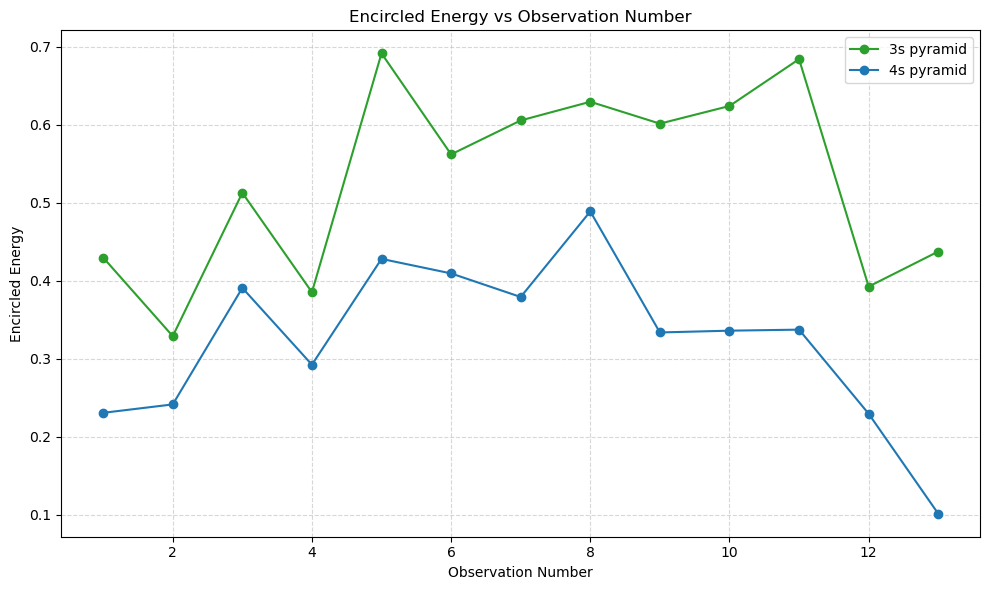

In [5]:
# --------------------------------------------------------------------
# Sort & assign observation pairs
# --------------------------------------------------------------------
df = pd.DataFrame(results).sort_values('datetime').reset_index(drop=True)
df['pair_index'] = np.floor(df.index / 2).astype(int) + 1

# --------------------------------------------------------------------
# Print Encircled Energy comparison table
# --------------------------------------------------------------------
print("\nEncircled Energy Comparison (3s vs 4s Pyramid):")
print("-" * 60)
print(f"{'Obs#':<6}{'EE (3s)':>12}{'EE (4s)':>12}{'Ratio (3s/4s)':>18}")
print("-" * 60)

ratios = []  # store all valid ratios

for i in sorted(df['pair_index'].unique()):
    ee_3s = df.loc[(df['pair_index'] == i) & (df['pyramid'] == '3s'), 'EE']
    ee_4s = df.loc[(df['pair_index'] == i) & (df['pyramid'] == '4s'), 'EE']
    if not ee_3s.empty and not ee_4s.empty:
        ratio = ee_3s.values[0] / ee_4s.values[0] if ee_4s.values[0] != 0 else np.nan
        ratios.append(ratio)
        print(f"{i:<6}{ee_3s.values[0]:>12.4f}{ee_4s.values[0]:>12.4f}{ratio:>18.4f}")

print("-" * 60)

# Compute average and standard deviation
ratios = np.array(ratios)
mean_ratio = np.nanmean(ratios)
std_ratio = np.nanstd(ratios)

print(f"\nAverage 3s/4s Ratio: {mean_ratio:.3f} ± {std_ratio:.3f}")

# --------------------------------------------------------------------
# Plot Encircled Energy vs Observation Number
# --------------------------------------------------------------------
plt.figure(figsize=(10, 6))

for pyr, color in zip(['3s', '4s'], ['tab:green', 'tab:blue']):
    sub = df[df['pyramid'] == pyr]
    plt.plot(sub['pair_index'], sub['EE'], 'o-', label=f'{pyr} pyramid', color=color)

plt.xlabel('Observation Number')
plt.ylabel('Encircled Energy')
plt.title('Encircled Energy vs Observation Number')
plt.grid(True, ls='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()


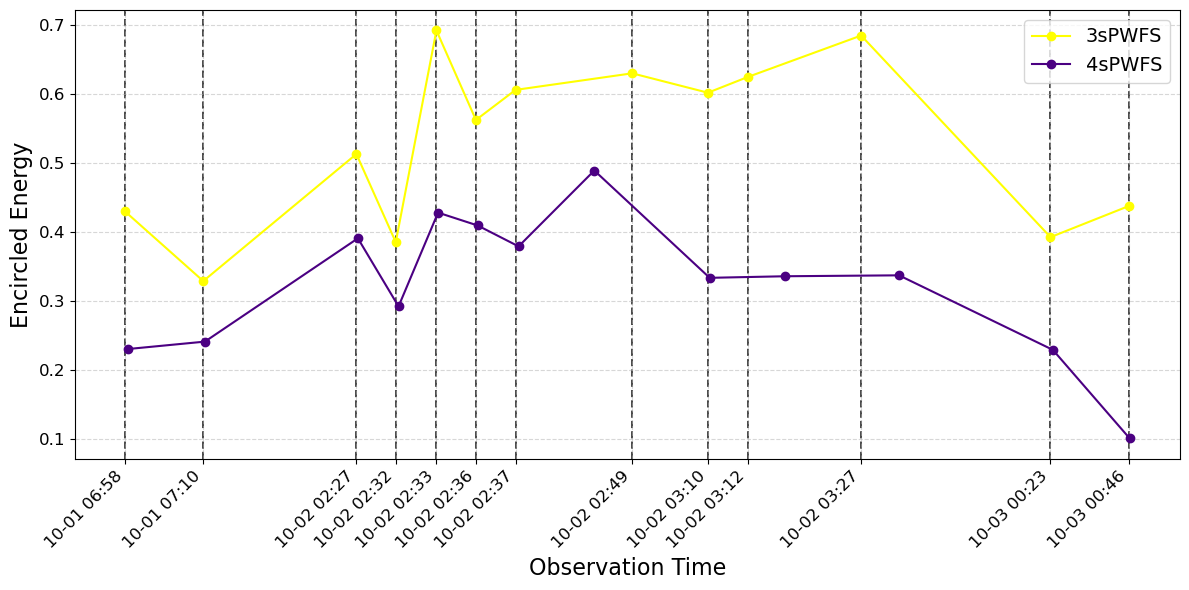

In [7]:
# --------------------------------------------------------------------
# Build compressed timeline 
# --------------------------------------------------------------------
df = pd.DataFrame(results).sort_values('datetime').reset_index(drop=True)
df['pair_index'] = np.floor(df.index / 2).astype(int) + 1
df['compressed_time'] = build_compressed_timeline(df)

# --- Tick labels (real datetimes from 3s PWFS frames) ---
tick_locs = df[df['pyramid'] == '3s']['compressed_time']
tick_labels = [dt.strftime('%m-%d %H:%M') for dt in df[df['pyramid'] == '3s']['datetime']]

# --- Plot ---
plt.figure(figsize=(12, 6))

# Custom dark colors
colors = {'3s': 'yellow',  # dark purple (indigo)
          '4s': '#4B0082'}  # rich dark blue

# Plot data
for pyr in ['3s', '4s']:
    sub = df[df['pyramid'] == pyr]
    plt.plot(sub['compressed_time'], sub['EE'], 'o-', label=f'{pyr}PWFS', color=colors[pyr])

# --- Add dark vertical guide lines only for 3s observations ---
for x in df[df['pyramid'] == '3s']['compressed_time']:
    plt.axvline(x, color='#333333', linestyle='--', alpha=0.9, linewidth=1.4, zorder=0)

# --- Aesthetics ---
plt.xlabel('Observation Time', fontsize=16)
plt.ylabel('Encircled Energy', fontsize=16)
plt.grid(True, ls='--', alpha=0.5)
plt.legend(fontsize=14, loc='upper right')

plt.xticks(tick_locs, tick_labels, rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.savefig("EE_VS_TIME_3S_LINES.png", dpi=300, transparent=True)
plt.show()


## RMS Residuals

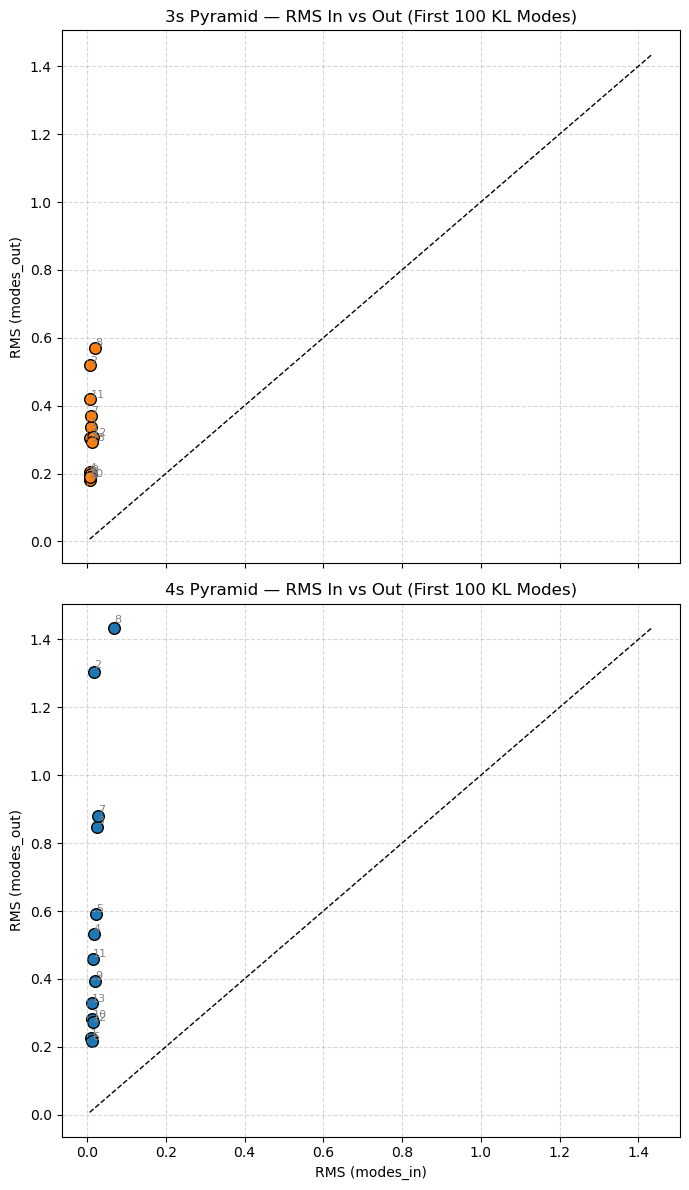

In [8]:

# --------------------------------------------------------------------
# Compute for both 3s and 4s pyramids
# --------------------------------------------------------------------
rms_in_3s, rms_out_3s, labels_3s = compute_rms_for_pyramid('3s')
rms_in_4s, rms_out_4s, labels_4s = compute_rms_for_pyramid('4s')

# Axis limits shared for visual consistency
min_lim = min(rms_in_3s + rms_out_3s + rms_in_4s + rms_out_4s)
max_lim = max(rms_in_3s + rms_out_3s + rms_in_4s + rms_out_4s)

# --------------------------------------------------------------------
# Plot: stacked (3s on top, 4s below)
# --------------------------------------------------------------------
fig, axes = plt.subplots(2, 1, figsize=(7, 12), sharex=True, sharey=True)

# --- 3s pyramid ---
ax = axes[0]
ax.scatter(rms_in_3s, rms_out_3s, s=70, color='tab:orange', edgecolor='k')
for i, lbl in enumerate(labels_3s):
    ax.text(rms_in_3s[i]*1.01, rms_out_3s[i]*1.01, str(i+1), fontsize=8, color='gray')
ax.plot([min_lim, max_lim], [min_lim, max_lim], 'k--', lw=1)
ax.set_title('3s Pyramid — RMS In vs Out (First 100 KL Modes)')
ax.set_ylabel('RMS (modes_out)')
ax.grid(True, ls='--', alpha=0.5)

# --- 4s pyramid ---
ax = axes[1]
ax.scatter(rms_in_4s, rms_out_4s, s=70, color='tab:blue', edgecolor='k')
for i, lbl in enumerate(labels_4s):
    ax.text(rms_in_4s[i]*1.01, rms_out_4s[i]*1.01, str(i+1), fontsize=8, color='gray')
ax.plot([min_lim, max_lim], [min_lim, max_lim], 'k--', lw=1)
ax.set_title('4s Pyramid — RMS In vs Out (First 100 KL Modes)')
ax.set_xlabel('RMS (modes_in)')
ax.set_ylabel('RMS (modes_out)')
ax.grid(True, ls='--', alpha=0.5)

plt.tight_layout()
plt.show()


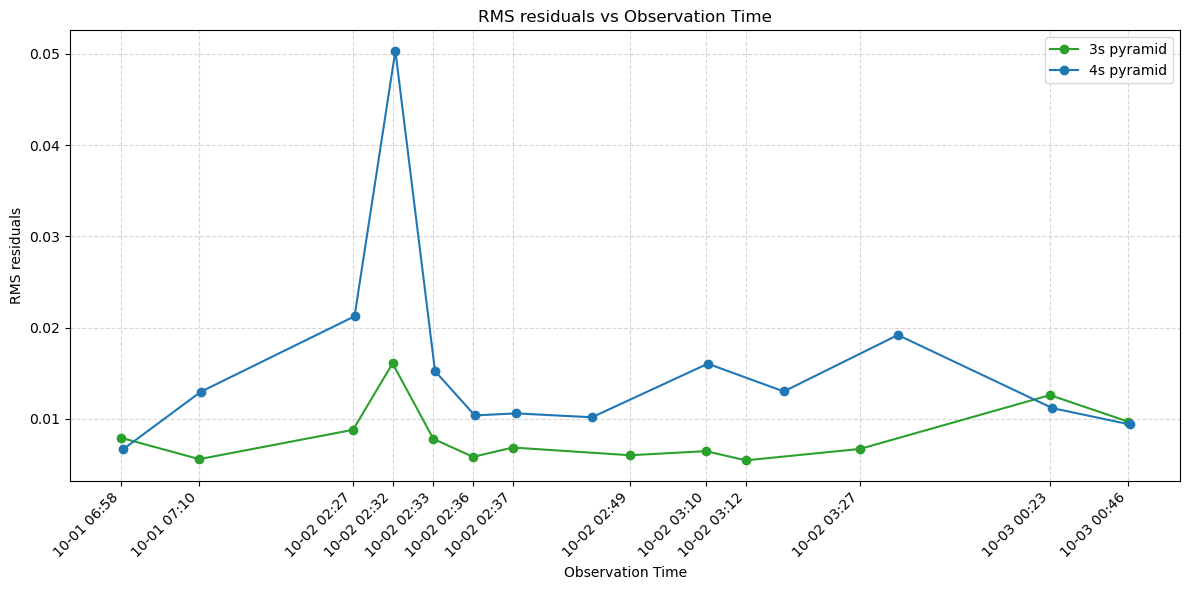

In [11]:
# --------------------------------------------------------------------
# Compute RMS of first 100 KL modes vs time
# --------------------------------------------------------------------
results = []
for folder in folders:
    try:
        pyramid = get_pyramid_type(folder)
        modes_in = fits.getdata(os.path.join(folder, 'modes_in.fits'))
        rms_modes_in_kl = compute_modes_rms_kl(modes_in)
        rms_in_100 = np.sqrt(np.mean(rms_modes_in_kl**2))
        dt = get_datetime_from_path(folder)

        results.append({
            'datetime': dt,
            'pyramid': pyramid,
            'RMS100': rms_in_100
        })
    except Exception as e:
        print(f"⚠️ Error in {folder}: {e}")

# --------------------------------------------------------------------
# Build compressed timeline 
# --------------------------------------------------------------------
df = pd.DataFrame(results).sort_values('datetime').reset_index(drop=True)
df['pair_index'] = np.floor(df.index / 2).astype(int) + 1
df['compressed_time'] = build_compressed_timeline(df)

# --------------------------------------------------------------------
# Tick labels (real datetimes from 3s pyramid only)
# --------------------------------------------------------------------
tick_locs = df[df['pyramid'] == '3s']['compressed_time']
tick_labels = [
    dt.strftime('%m-%d %H:%M')
    for dt in df[df['pyramid'] == '3s']['datetime']
]

# --------------------------------------------------------------------
# Plot RMS vs Time (Daytime Gaps Removed)
# --------------------------------------------------------------------
plt.figure(figsize=(12, 6))

for pyr, color in zip(['3s', '4s'], ['tab:green', 'tab:blue']):
    sub = df[df['pyramid'] == pyr]
    plt.plot(sub['compressed_time'], sub['RMS100'], 'o-',
             label=f'{pyr} pyramid', color=color)

plt.xlabel('Observation Time')
plt.ylabel('RMS residuals')
plt.title('RMS residuals vs Observation Time')
plt.grid(True, ls='--', alpha=0.5)
plt.legend()

plt.xticks(tick_locs, tick_labels, rotation=45, ha='right')
plt.tight_layout()
plt.savefig("RMS_residuals_vs_Time.png", dpi=300)
plt.show()


## Jitter

In [12]:
# --------------------------------------------------------------------
# First-level cropping (common for both pyramids)
# --------------------------------------------------------------------
crop_common = {
    '30.09.25': dict(y0=220, y1=320, x0=275, x1=375),
    '01.10.25': dict(y0=200, y1=400, x0=225, x1=425),
    '02.10.25': dict(y0=220, y1=320, x0=285, x1=385),
}

# --------------------------------------------------------------------
# Second-level cropping (relative to the first)
# --------------------------------------------------------------------
crop_inner = {
    "3s": {
        "30.09.25": dict(y0=44, y1=74, x0=35, x1=65),
        "01.10.25": dict(y0=60, y1=90, x0=85, x1=115),
        "02.10.25": dict(y0=40, y1=70, x0=30, x1=60),
    },
    "4s": {
        "30.09.25": dict(y0=30, y1=60, x0=40, x1=70),
        "01.10.25": dict(y0=52, y1=82, x0=88, x1=118),
        "02.10.25": dict(y0=35, y1=65, x0=36, x1=66),
    },
}

# --------------------------------------------------------------------
# Main computation
# --------------------------------------------------------------------
results = []

for folder in folders:
    pyr = get_pyramid_type(folder)
    date = get_date_from_path(folder)
    dt = get_datetime_from_path(folder)

    try:
        # --- Load cube ---
        cube = fits.getdata(os.path.join(folder, "cred2.fits")).astype(float)

        # --- 1st-level crop (common window) ---
        c1 = crop_common[date]
        subcube = cube[:, c1['y0']:c1['y1'], c1['x0']:c1['x1']]

        # --- 2nd-level crop (within the cropped region) ---
        c2 = crop_inner[pyr][date]
        psf_data = subcube[:, c2['y0']:c2['y1'], c2['x0']:c2['x1']]

        # --- Compute frame-by-frame positions ---
        N = psf_data.shape[0]
        peak_x, peak_y, com_x, com_y = np.empty(N), np.empty(N), np.empty(N), np.empty(N)

        for i in range(N):
            img = psf_data[i]
            ypk, xpk = np.unravel_index(np.argmax(img), img.shape)
            ycm, xcm = center_of_mass(img**5)
            peak_x[i], peak_y[i], com_x[i], com_y[i] = xpk, ypk, xcm, ycm

        # --- Standard deviations ---
        px_std = np.nanstd(peak_x)
        py_std = np.nanstd(peak_y)
        cx_std = np.nanstd(com_x)
        cy_std = np.nanstd(com_y)

        results.append(dict(
            datetime=dt, date=date, pyramid=pyr,
            px_std=px_std, py_std=py_std,
            cx_std=cx_std, cy_std=cy_std
        ))

    except Exception as e:
        print(f"❌ Error in {folder}: {e}")

# --------------------------------------------------------------------
# Summary table
# --------------------------------------------------------------------
df = pd.DataFrame(results).sort_values("datetime").reset_index(drop=True)
print(df.round(4))


              datetime      date pyramid  px_std  py_std  cx_std  cy_std
0  2025-10-01 06:58:49  30.09.25      3s  0.3919  0.4996  0.3423  0.2106
1  2025-10-01 06:59:09  30.09.25      4s  0.3919  1.0553  0.2220  0.1957
2  2025-10-01 07:10:33  30.09.25      3s  0.0000  0.0000  0.1239  0.1909
3  2025-10-01 07:10:46  30.09.25      4s  0.6013  1.0628  0.3615  0.4349
4  2025-10-02 02:27:34  01.10.25      3s  0.8998  0.7526  0.7993  0.5816
5  2025-10-02 02:27:46  01.10.25      4s  0.3666  0.6499  0.2296  0.5784
6  2025-10-02 02:32:36  01.10.25      3s  1.6608  0.7526  0.4388  0.3314
7  2025-10-02 02:32:58  01.10.25      4s  1.0583  2.1541  0.3806  0.8501
8  2025-10-02 02:33:47  01.10.25      3s  0.4964  0.4800  0.3725  0.3425
9  2025-10-02 02:34:00  01.10.25      4s  0.4800  0.4899  0.1874  0.3478
10 2025-10-02 02:36:37  01.10.25      3s  0.1960  0.0000  0.1722  0.1770
11 2025-10-02 02:36:51  01.10.25      4s  0.0000  0.1960  0.0833  0.1462
12 2025-10-02 02:37:57  01.10.25      3s  0.8523  0

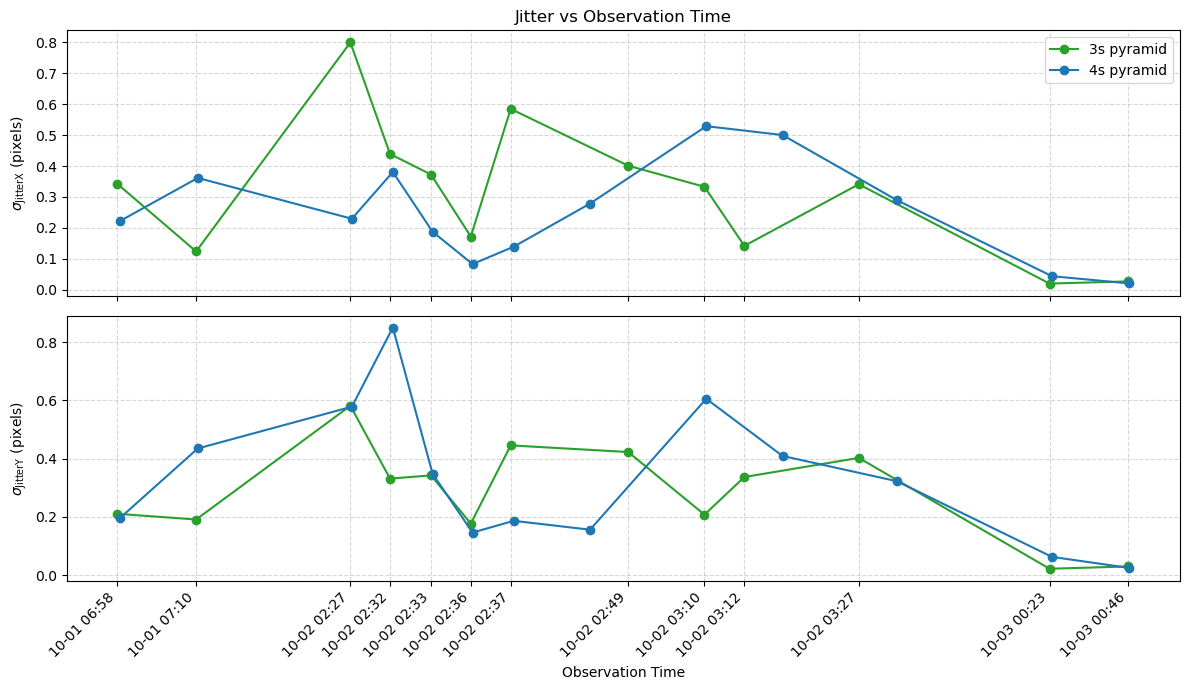

In [13]:
# --------------------------------------------------------------------
# Build compressed timeline 
# --------------------------------------------------------------------
df = df.sort_values('datetime').reset_index(drop=True)
df['compressed_time'] = build_compressed_timeline(df)

# --------------------------------------------------------------------
# Use 3s pyramid times for tick labels (clean timeline)
# --------------------------------------------------------------------
tick_locs = df[df['pyramid'] == '3s']['compressed_time']
tick_labels = [
    dt.strftime('%m-%d %H:%M')
    for dt in df[df['pyramid'] == '3s']['datetime']
]

# --------------------------------------------------------------------
# Plot cx_std and cy_std vs time
# --------------------------------------------------------------------
fig, ax = plt.subplots(2, 1, figsize=(12, 7), sharex=True)

# ---- cx_std ----
for pyr, color in zip(['3s', '4s'], ['tab:green', 'tab:blue']):
    sub = df[df['pyramid'] == pyr]
    ax[0].plot(sub['compressed_time'], sub['cx_std'], 'o-',
               color=color, label=f'{pyr} pyramid')

ax[0].set_ylabel(r'$\sigma_{\mathrm{JitterX}}\ (\mathrm{pixels})$')
ax[0].set_title('Jitter vs Observation Time')
ax[0].grid(True, ls='--', alpha=0.5)
ax[0].legend()

# ---- cy_std ----
for pyr, color in zip(['3s', '4s'], ['tab:green', 'tab:blue']):
    sub = df[df['pyramid'] == pyr]
    ax[1].plot(sub['compressed_time'], sub['cy_std'], 'o-',
               color=color, label=f'{pyr} pyramid')

ax[1].set_ylabel(r'$\sigma_{\mathrm{JitterY}}\ (\mathrm{pixels})$')
ax[1].set_xlabel('Observation Time')
ax[1].grid(True, ls='--', alpha=0.5)

# Shared x-axis formatting
plt.xticks(tick_locs, tick_labels, rotation=45, ha='right')

plt.tight_layout()
plt.savefig("Jitter_vs_Time.png", dpi=300)
plt.show()


In [14]:
modes_out = fits.getdata(os.path.join(folder_data, 'modes_out.fits'))

jx_std = np.nanstd(modes_out[:, 0])
jy_std = np.nanstd(modes_out[:, 1])


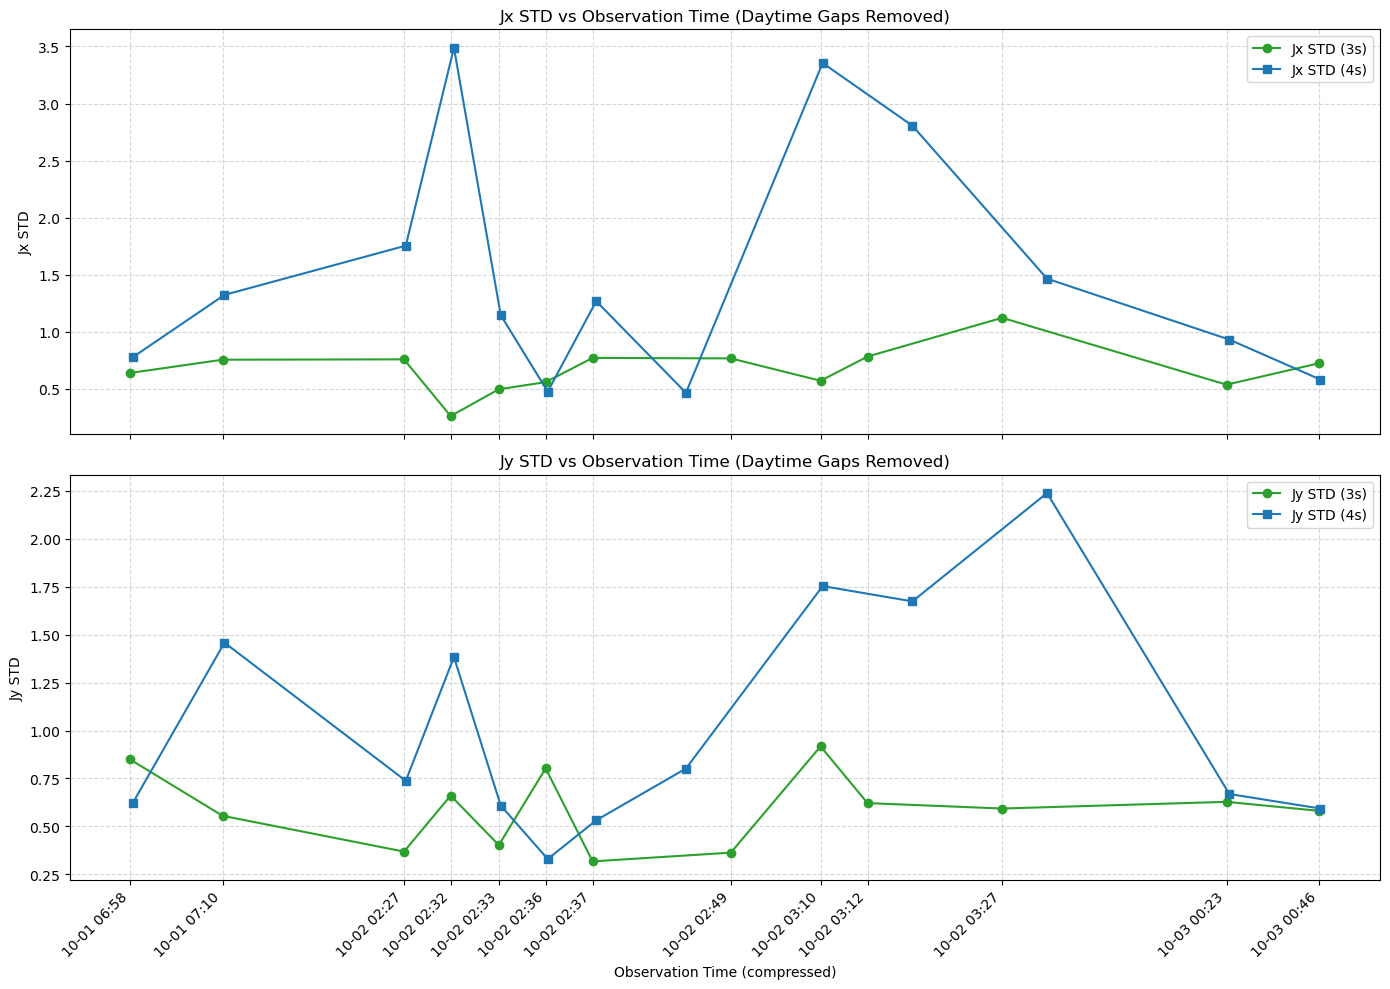

In [15]:
# --------------------------------------------------------------------
# Compute jitter std vs time
# --------------------------------------------------------------------
results = []
for folder in folders:
    try:
        pyramid = get_pyramid_type(folder)
        modes_out = fits.getdata(os.path.join(folder, 'modes_out.fits'))

        jx = modes_out[:, 0]
        jy = modes_out[:, 1]

        jx_std = np.nanstd(jx)
        jy_std = np.nanstd(jy)

        dt = get_datetime_from_path(folder)

        results.append({
            'datetime': dt,
            'pyramid': pyramid,
            'jx_std': jx_std,
            'jy_std': jy_std
        })

    except Exception as e:
        print(f"⚠️ Error in {folder}: {e}")

# --------------------------------------------------------------------
# Build compressed timeline 
# --------------------------------------------------------------------
df = pd.DataFrame(results).sort_values('datetime').reset_index(drop=True)
df['compressed_time'] = build_compressed_timeline(df)

# --------------------------------------------------------------------
# Tick labels – based on 3s pyramid only (clean timeline)
# --------------------------------------------------------------------
tick_locs = df[df['pyramid'] == '3s']['compressed_time']
tick_labels = [
    dt.strftime('%m-%d %H:%M')
    for dt in df[df['pyramid'] == '3s']['datetime']
]

# --------------------------------------------------------------------
# Plot: Jx STD (top) and Jy STD (bottom)
# --------------------------------------------------------------------
fig, axes = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# --- Jx STD ---
for pyr, marker, color in zip(['3s', '4s'], ['o', 's'], ['tab:green', 'tab:blue']):
    sub = df[df['pyramid'] == pyr]
    axes[0].plot(sub['compressed_time'], sub['jx_std'], marker+'-',
                 label=f'Jx STD ({pyr})', color=color)

axes[0].set_ylabel('Jx STD')
axes[0].set_title('Jx STD vs Observation Time (Daytime Gaps Removed)')
axes[0].grid(True, ls='--', alpha=0.5)
axes[0].legend()

# --- Jy STD ---
for pyr, marker, color in zip(['3s', '4s'], ['o', 's'], ['tab:green', 'tab:blue']):
    sub = df[df['pyramid'] == pyr]
    axes[1].plot(sub['compressed_time'], sub['jy_std'], marker+'-',
                 label=f'Jy STD ({pyr})', color=color)

axes[1].set_ylabel('Jy STD')
axes[1].set_title('Jy STD vs Observation Time (Daytime Gaps Removed)')
axes[1].grid(True, ls='--', alpha=0.5)
axes[1].legend()

# Shared x-axis formatting
plt.xticks(tick_locs, tick_labels, rotation=45, ha='right')
plt.xlabel("Observation Time (compressed)")

plt.tight_layout()
plt.show()
